In [55]:
import cv2
import json
import treepoem
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

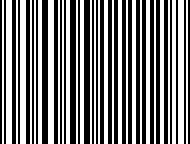

In [2]:
barimg = treepoem.generate_barcode('ean13', '100000011111')
barimg

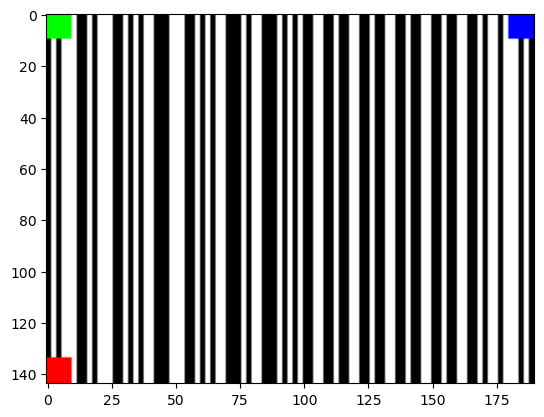

In [4]:
bar = np.array(barimg).copy()
bar[-10:, :10] = [255, 0, 0]
bar[:10, :10] = [0, 255, 0]
bar[:10, -10:] = [0, 0, 255]

plt.imshow(bar)

In [50]:
def aligned_affine(bar, M, fix_position=True):
    xps = [0, 0, 1, 1]
    yps = [1, 0, 0, 1]
    
    height, width, _ = bar.shape
    corners = np.array([[x*width, y*height, 1] for x, y in zip(xps, yps)]).T
    
    if fix_position:
        M[:,-1] = -np.min(M@corners, axis=-1)
    new_sz = np.ceil(np.max(M@corners, axis=-1)).astype(np.int32)
    img = cv2.warpAffine(bar, M, new_sz)
    return img, M@corners

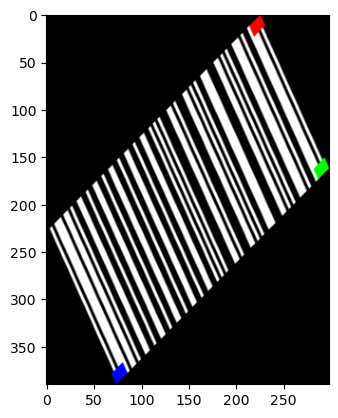

In [53]:
M = [
    [1, 0, 0.],
    [0, 1, 0.]
]
M = np.array(M)
img, coords = aligned_affine(bar, np.random.randn(2, 3))
plt.imshow(img)

In [59]:
def export(img, coords, name, barcodetype):
    plt.imsave(f'{name}.jpg', img)
    ptsx, ptsy = coords
    res = {f'{name}.jpg813086': {'filename': f'../code/{name}.jpg',
    'size': 813086,
    'regions': [{
        'shape_attributes': {
            'name': 'polygon',
            'all_points_x': list(ptsx),
            'all_points_y': list(ptsy)
        },
        'region_attributes': {'barcode': barcodetype}},
    ],
    'file_attributes': {}}}
    save_json(res, f'{name}.json')

In [60]:
export(img, coords, 'test', '1d')

In [18]:
def load_json(fname, *args, **kwargs):
    with open(fname) as f:
        return json.load(f, *args, **kwargs)

def save_json(jd, fname, *args, indent=4, **kwargs):
    with open(fname, 'w') as f:
        json.dump(jd, f, *args, indent=indent, **kwargs)

In [19]:
load_json('../dataset/multiple_barcodes_example.json')

{'IMG_20240320_184618_340.jpg813086': {'filename': 'IMG_20240320_184618_340.jpg',
  'size': 813086,
  'regions': [{'shape_attributes': {'name': 'polygon',
     'all_points_x': [655, 660, 586, 583],
     'all_points_y': [594, 774, 774, 592]},
    'region_attributes': {'barcode': '1d'}},
   {'shape_attributes': {'name': 'polygon',
     'all_points_x': [366, 451, 450, 366],
     'all_points_y': [1356, 1356, 1445, 1444]},
    'region_attributes': {'barcode': '2d'}}],
  'file_attributes': {}}}

In [66]:
treepoem.barcode_types['qrcode']